In [1]:
import math
import sys
import os
import pandas as pd
import numpy as np
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from overfitting import Strategy

In [2]:
# Define Constants
INITIAL_CAPTIAL=100000
SYMBOL = 'BTC'
CSV_PATH = './csv/binance_futures_BTCUSDT_1h 2019-09-09-2024-08-29.csv'
START_TIME='2023-01-01 00:00:00'
END_TIME='2024-08-29 00:00:00'

In [3]:
def directional_change(close: np.array, high: np.array, low: np.array, sigma: float):
    up_zig = True
    tmp_max = high[0]
    tmp_min = low[0]
    tmp_max_i = 0
    tmp_min_i = 0

    tops = []
    bottoms = []

    for i in range(len(close)):
        if up_zig == True: # the last extreme is a bottom
            if high[i] > tmp_max:
                # New high Update
                tmp_max = high[i]
                tmp_max_i = i
            elif close[i] < tmp_max - tmp_max * sigma:
                # Price retraced by sigma %. Top confirmed Record it
                # top[0] = confirmation index
                # top[1] = index
                # top[2] = price
                top = [i, tmp_max_i, tmp_max]
                tops.append(top)

                # Setup for next bottom
                up_zig = False
                tmp_min = low[i]
                tmp_min_i = i
        else: # the last extreme is a top
            if low[i] < tmp_min:
                # New low update
                tmp_min = low[i]
                tmp_min_i = i
            elif close[i] > tmp_min + tmp_min * sigma:
                # Trend reversed, record it
                # bottom[0] = confirmation index
                # bottom[1] = index
                # bottom[2] = price
                bottom = [i, tmp_min_i, tmp_min]
                bottoms.append(bottom)

                # Setup for next top
                up_zig=True
                tmp_max = high[i]
                tmp_max_i = i

    return tops, bottoms

In [4]:
def load_data(csv_path, start_time, end_time):
    # Load the CSV file into DataFrame
    df = pd.read_csv(csv_path)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df.set_index('open_time', inplace=True)
    # Drop unnecessary columns
    df = df.drop(['close_time', 'volume'], axis=1)
        
    # Convert the relevant columns to numpy arrays
    high = df['high'].values
    low = df['low'].values
    close = df['close'].values
    # Apply the Gann Swing Chart calculation
    tops, bottoms = directional_change(close, high, low, 0.018)

    # Store the tops and bottoms in the dataframe
    df['swing_top'] = np.nan
    df['swing_bottom'] = np.nan

    for top in tops:
        # Allocate tops in the corresponding index
        df.at[df.index[top[1]+ 1], 'swing_top'] = top[2]

    for bottom in bottoms:
        # Allocate tops in the corresponding index
        df.at[df.index[bottom[1] + 1], 'swing_bottom'] = bottom[2]

    # Convert start_time and end_time to datetime
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    # Filter the dataframe by the start and end time
    df = df.loc[start_time:end_time]


    return df

# Example usage
backtest_data = load_data(CSV_PATH, START_TIME, END_TIME)
print(backtest_data.head())


                              open           high            low  \
open_time                                                          
2023-01-01 00:00:00 16537.50000000 16540.90000000 16504.00000000   
2023-01-01 01:00:00 16527.10000000 16554.30000000 16524.10000000   
2023-01-01 02:00:00 16550.50000000 16557.10000000 16534.80000000   
2023-01-01 03:00:00 16542.50000000 16542.50000000 16515.00000000   
2023-01-01 04:00:00 16529.20000000 16530.40000000 16508.80000000   

                             close  swing_top  swing_bottom  
open_time                                                    
2023-01-01 00:00:00 16527.00000000        NaN           NaN  
2023-01-01 01:00:00 16550.40000000        NaN           NaN  
2023-01-01 02:00:00 16542.40000000        NaN           NaN  
2023-01-01 03:00:00 16529.30000000        NaN           NaN  
2023-01-01 04:00:00 16517.80000000        NaN           NaN  


In [5]:
class MyStrategy(Strategy):
    def init(self):
        # Performance Analysis
        self.ups = 0
        self.downs = 0
        self.ups_edge = 0
        self.downs_edge = 0
        self.total_ups = 0
        self.total_downs = 0

        # Variables for swing trend detection
        self.prev_swing_top = None
        self.current_swing_top = None
        self.prev_swing_bottom = None
        self.current_swing_bottom = None
        self.current_trend = None

        self.is_close_position = False

    def next(self, i):
        price = self.data.open[i]
        prev_low = self.data.low[i-1]
        prev_high = self.data.high[i-1]

        swing_top = self.data.swing_top[i]
        swing_bottom = self.data.swing_bottom[i]
        time = pd.to_datetime(self.data.timestamp[i])
        
        p = self.get_position(SYMBOL)

        if self.is_close_position == True and p.qty != 0:
            self.market_order(SYMBOL, -p.qty)
            self.is_close_position = False

        # Look for new trends when not in a position
        if self.current_trend is None:
            a = (self.broker.cash / price) * 1000
            size = math.floor(a) / 1000

            if self.current_swing_bottom and self.prev_swing_bottom and self.current_swing_bottom > self.prev_swing_bottom:
                # Check for the uptrend
                if prev_high > self.current_swing_top:
                    # Starts the uptrend, enter position
                    self.market_order(SYMBOL, size)
                    self.current_trend = 'up'

            elif self.current_swing_top and self.prev_swing_top and self.current_swing_top < self.prev_swing_top:
                # Check for the downtrend
                if prev_low < self.current_swing_bottom:
                    # Starts the downtrend, enter position
                    # self.market_order(SYMBOL, -size)
                    self.current_trend = 'down'

        # Detect new swing top and bottom
        if not pd.isna(swing_top):
            self.prev_swing_top = self.current_swing_top if self.current_swing_top else None
            self.current_swing_top = swing_top
            if self.current_trend == 'up':
                # Close the uptrend position when swing top is confirmed
                self.is_close_position = True

                self.current_trend = None

        if not pd.isna(swing_bottom):
            self.prev_swing_bottom = self.current_swing_bottom if self.current_swing_bottom else None
            self.current_swing_bottom = swing_bottom
            if self.current_trend == 'down':
                # Close the downtrend position in the next loop when swing bottom is confirmed
                self.is_close_position = True
                self.current_trend = None

In [6]:
strategy = MyStrategy(backtest_data)
returns = strategy.run()

In [7]:
strategy.fetch_trades()

,id,created_at,symbol,qty,price,type,_status,stop_price,trailing_delta,is_triggered,reason,commission,pnl,realized_pnl
0,79487eef,2023-01-12 18:00:00,BTC,53.07800000,18840.00000000,Enum.market,Enum.FILLED,None,None,False,None,199.99790400,0.00000000,-199.99790400
1,e8c035b3,2023-01-12 23:00:00,BTC,-53.07800000,18907.40000000,Enum.market,Enum.FILLED,None,None,False,None,200.71339544,3577.45720000,3376.74380456
2,85ca4d5f,2023-01-13 15:00:00,BTC,52.82600000,18990.00000000,Enum.market,Enum.FILLED,None,None,False,None,200.63314800,0.00000000,-200.63314800
3,29f14df9,2023-01-14 02:00:00,BTC,-52.82600000,20934.30000000,Enum.market,Enum.FILLED,None,None,False,None,221.17506636,102709.59180000,102488.41673364
4,5b96b9e5,2023-01-16 21:00:00,BTC,51.91200000,21294.80000000,Enum.market,Enum.FILLED,None,None,False,None,221.09113152,0.00000000,-221.09113152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,96dde312,2024-08-23 16:00:00,BTC,-39.32300000,61498.60000000,Enum.market,Enum.FILLED,None,None,False,None,483.66188956,21509.68100000,21026.01911044
324,c4e2f19e,2024-08-26 00:00:00,BTC,37.66000000,64190.10000000,Enum.market,Enum.FILLED,None,None,False,None,483.47983320,0.00000000,-483.47983320
325,4e99bf96,2024-08-26 01:00:00,BTC,-37.66000000,64068.10000000,Enum.market,Enum.FILLED,None,None,False,None,482.56092920,-4594.52000000,-5077.08092920
326,fe946b0a,2024-08-28 10:00:00,BTC,40.08600000,60166.30000000,Enum.market,Enum.FILLED,None,None,False,None,482.36526036,0.00000000,-482.36526036


Number of Years : 1.7
Asset: USDT
Start Date: 2023-01-01 00:00:00
End Date: 2024-08-29 00:00:00
Initial Balnace: 1000000
Final Balance: 2393479.8458821233
CAGR 0.6709316723573049
Culmulative Return: 2.3934798458821196
Sharpe Ratio: 2.515240458685154
Sortino: 6.711802269971369
Max Drawdown: -0.09423985134456014 
Daily Value At Risk: -0.02131083179597027
Skew: 1.0084387062041276
Kurtosis: 3.195363490274672
  Net drawdown in %  Peak date Valley date Recovery date Duration
0        9.42398513 2023-03-19  2023-05-03    2023-10-24      157
1        6.04669458 2024-01-09  2024-02-07    2024-02-09       24
2        5.20254163 2024-08-10  2024-08-28           NaT      NaN
3        3.42249795 2023-02-06  2023-03-12    2023-03-17       30
4        3.36798801 2024-04-30  2024-05-02    2024-05-04        4
5        3.14912909 2023-01-15  2023-01-19    2023-01-21        5
6        2.61911657 2024-02-17  2024-02-26    2024-02-27        7
7        2.49293190 2024-02-28  2024-03-03    2024-03-06        

/Users/kimdohyun/Desktop/github/Overfitting/overfitting/plot/plot.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = cumulative_returns[-1]
/Users/kimdohyun/Desktop/github/Overfitting/overfitting/plot/plot.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns_series = (1+ returns_series).resample('M').prod() -1
/Users/kimdohyun/Desktop/github/Overfitting/overfitting/plot/plot.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Culmulative Return: {cumulative_returns[-1]}')


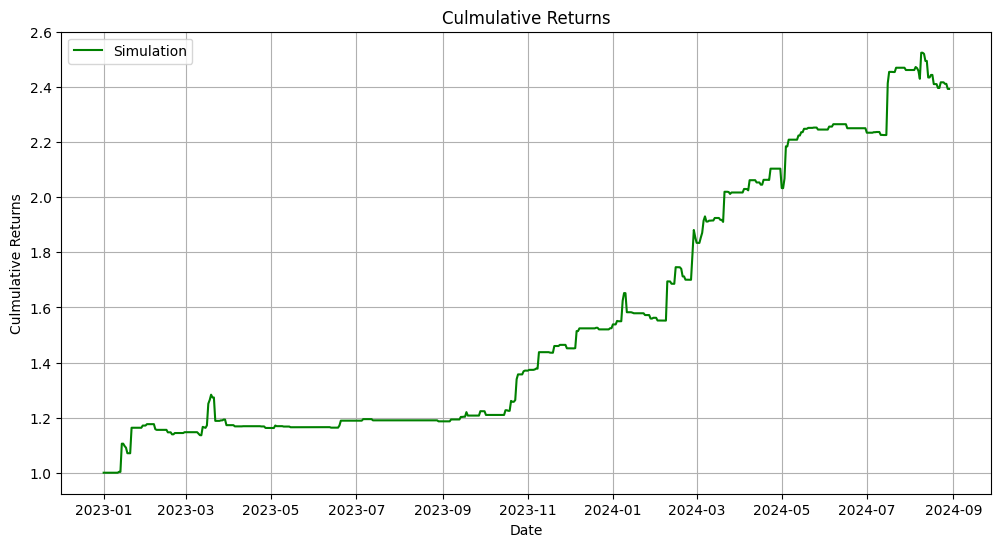

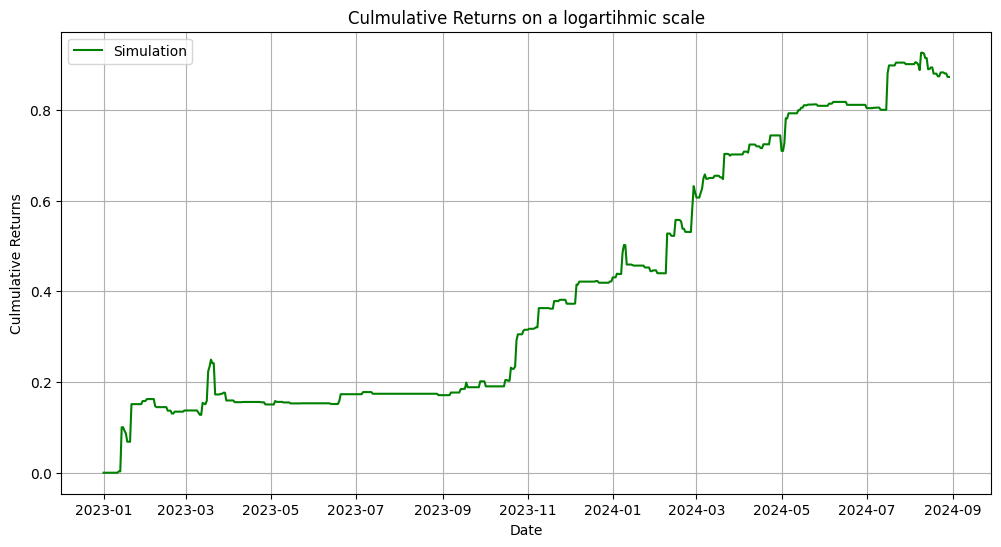

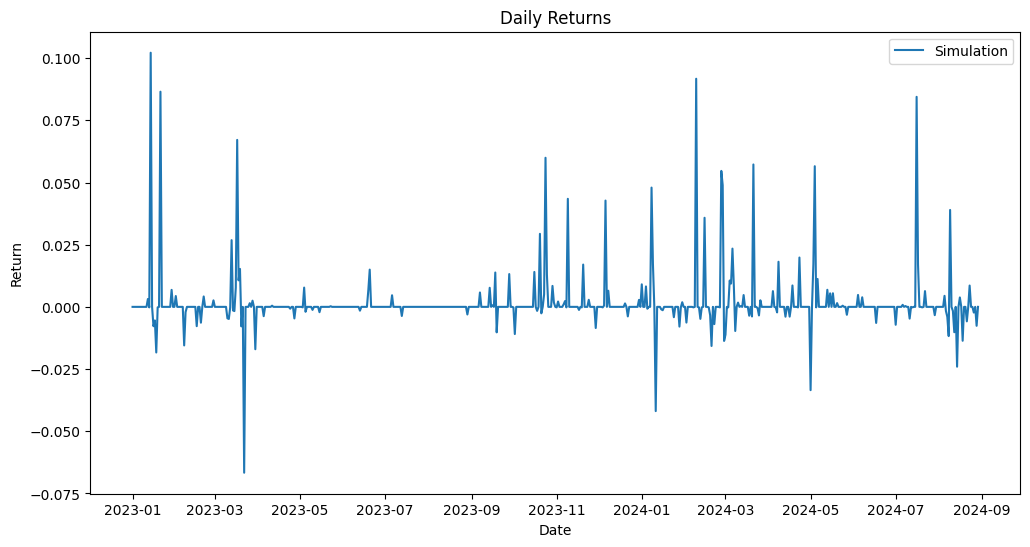

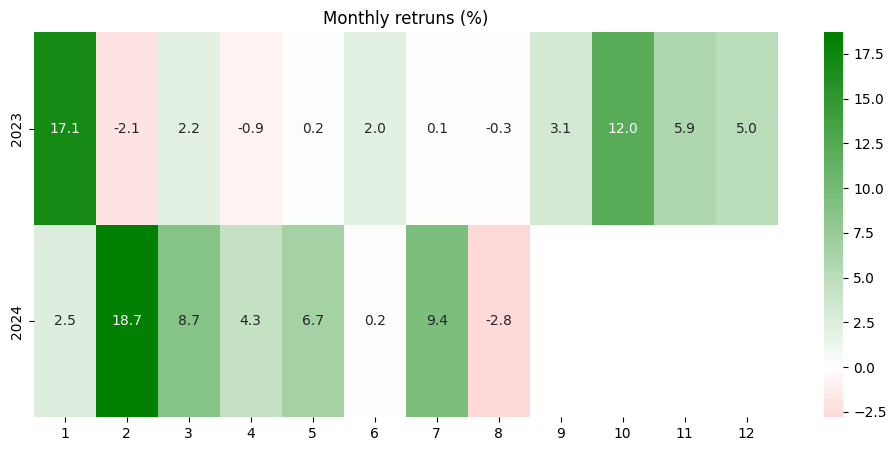

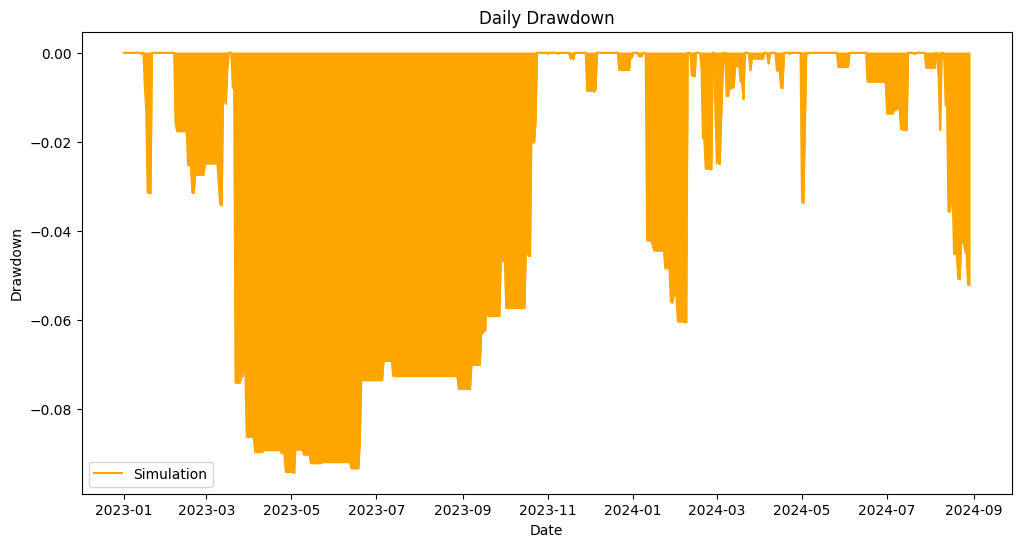

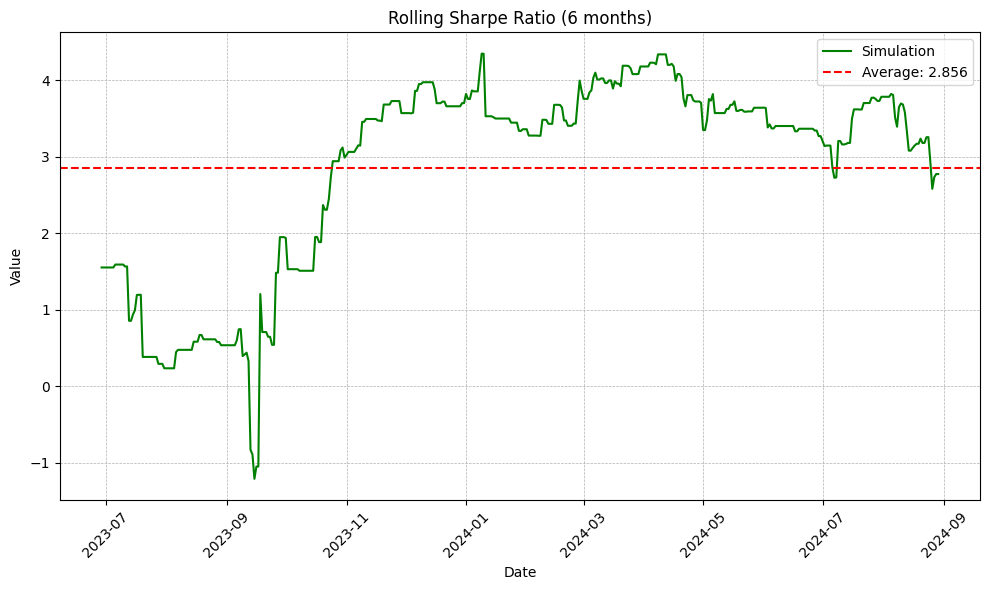

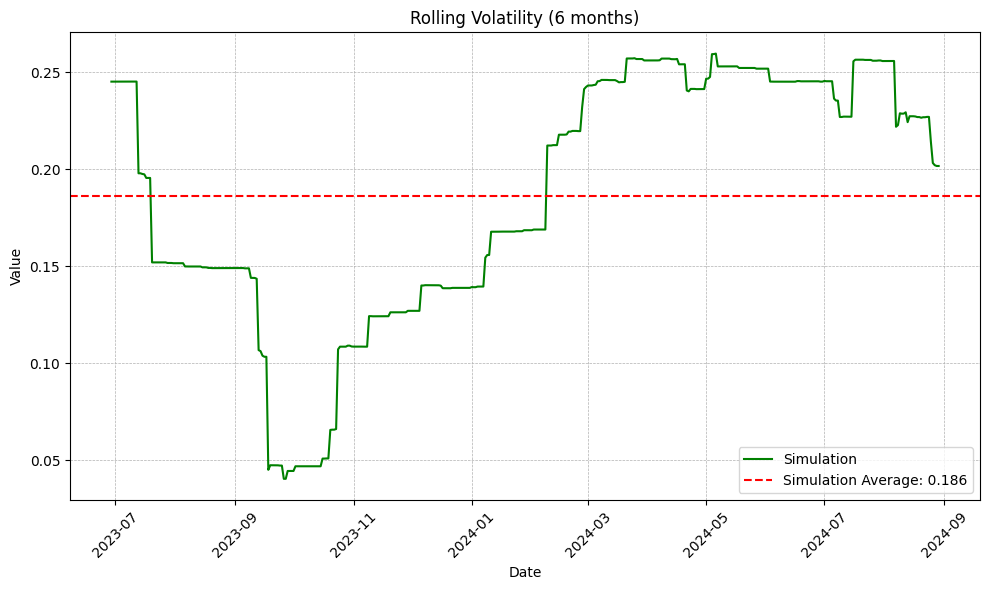

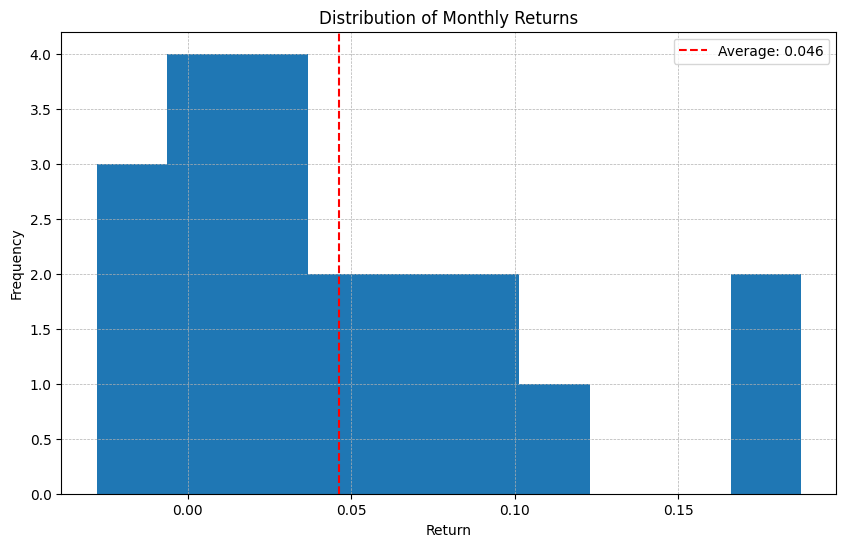

In [8]:
strategy.plot(returns, START_TIME, END_TIME)